In [ ]:
# import system libs
import os
import itertools
from PIL import Image # pillow

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

print ('modules loaded')



modules loaded


In [ ]:
# Generate data paths with labels
train_data_dir = 'Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df

,filepaths,labels
0,Training/pituitary/Tr-pi_0505.jpg,pituitary
1,Training/pituitary/Tr-pi_0263.jpg,pituitary
2,Training/pituitary/Tr-pi_0277.jpg,pituitary
3,Training/pituitary/Tr-pi_1169.jpg,pituitary
4,Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,Training/meningioma/Tr-me_1053.jpg,meningioma
5708,Training/meningioma/Tr-me_0403.jpg,meningioma
5709,Training/meningioma/Tr-me_0365.jpg,meningioma
5710,Training/meningioma/Tr-me_0371.jpg,meningioma


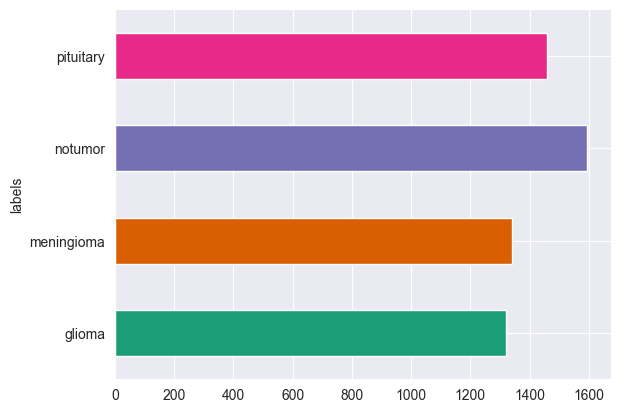

In [ ]:
# @title labels

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:

test_data_dir = 'Testing'
filepaths = []
labels = []

# Ensure 'Testing' directory exists
if os.path.isdir(test_data_dir):
    folds = os.listdir(test_data_dir)
    for fold in folds:
        foldpath = os.path.join(test_data_dir, fold)
        
        # Check if foldpath is a directory
        if os.path.isdir(foldpath):
            filelist = os.listdir(foldpath)
            for file in filelist:
                fpath = os.path.join(foldpath, file)

                filepaths.append(fpath)
                labels.append(fold)
        else:
            print(f"{foldpath} is not a directory.")
else:
    print(f"Directory '{test_data_dir}' does not exist.")

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis=1)


Testing/.DS_Store is not a directory.


In [ ]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


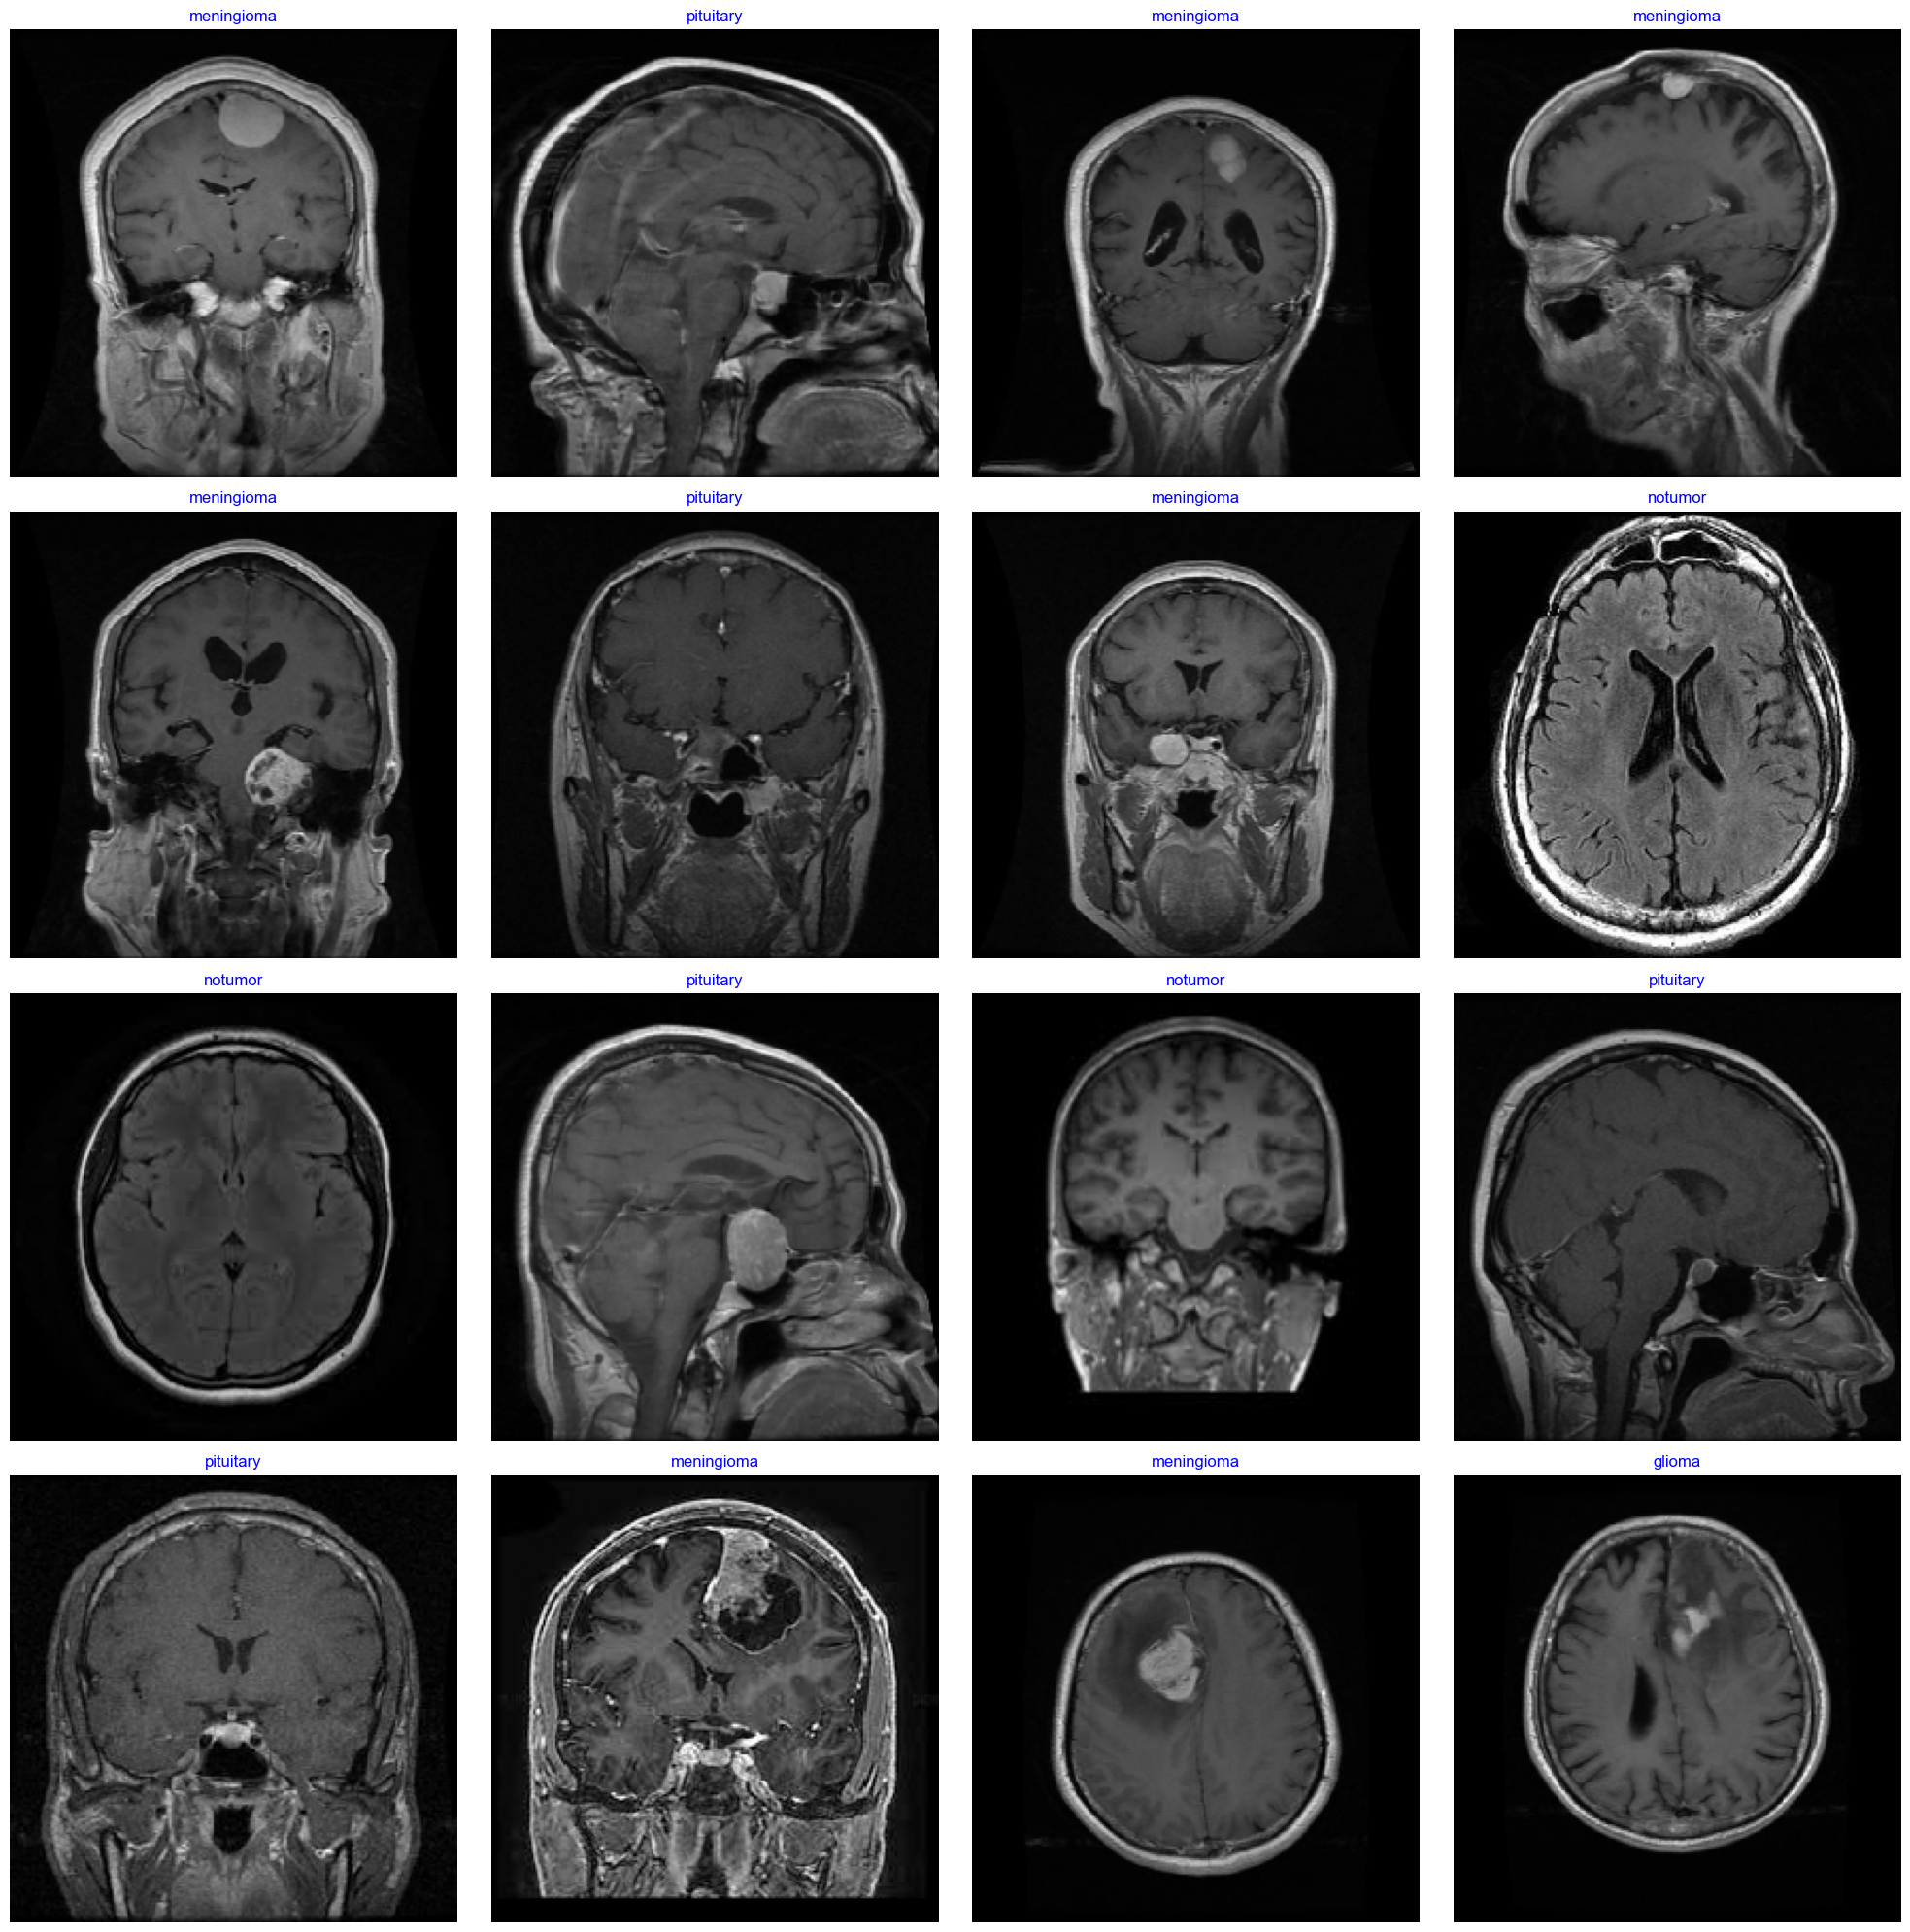

In [22]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size= (3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,180 (80.70 MB)

 Trainable params: 21,154,180 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

In [ ]:
from tensorflow.keras.models import save_model

# Define the file path to save the model
model_file_path = "model.h5"

# Save the model
model.save(model_file_path)

print("Model saved successfully as:", model_file_path)


Model saved successfully as: model.h5


In [51]:

import cv2
import numpy as np
from tensorflow.keras.models import load_model

In [77]:
cnn_model = load_model('model.h5')

In [57]:
net = cv2.dnn.readNetFromDarknet('darknet/cfg/yolov4_new.cfg', 'darknet/yolov4.weights')
with open("darknet/data/coco.names", "r") as f:
    classes = f.read().strip().split('\n')

In [83]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your CNN model
cnn_model = load_model('model.h5')

# Perform object detection using YOLO
def perform_object_detection(image_path):
    # Load image
    image = cv2.imread(image_path)
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    # Load YOLO model
    net = cv2.dnn.readNetFromDarknet('darknet/cfg/yolov4_new.cfg', 'darknet/yolov4.weights')
    with open("darknet/data/coco.names", "r") as f:
        classes = f.read().strip().split('\n')

    net.setInput(blob)
    layer_names = net.getLayerNames()

    # Get unconnected output layers
    unconnected_out_layers = net.getUnconnectedOutLayers()

    # List to store predictions
    predictions = []

    # Iterate over each unconnected output layer
    for layer_index in unconnected_out_layers:
        output_layers = [layer_names[layer_index - 1]]

        outputs = net.forward(output_layers)

        # Process outputs
        for output in outputs:
            # Process each output individually
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:  # You can adjust the confidence threshold as needed
                    center_x = int(detection[0] * image.shape[1])
                    center_y = int(detection[1] * image.shape[0])
                    w = int(detection[2] * image.shape[1])
                    h = int(detection[3] * image.shape[0])
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    # Extract the object image
                    object_img = image[y:y+h, x:x+w]

                    # Preprocess the object image
                    preprocessed_img = cv2.resize(object_img, (224, 224))  # Example resize

                    # Make predictions with the CNN model
                    prediction = cnn_model.predict(np.expand_dims(preprocessed_img, axis=0))

                    # Append prediction to list
                    predictions.append((object_img, prediction, (x, y, x+w, y+h)))

    return predictions

# Example usage
image_path = 'Testing/notumor/Te-no_0011.jpg'
detected_objects = perform_object_detection(image_path)

# Draw bounding boxes and display images
for object_img, prediction, bbox in detected_objects:
    # Draw bounding box
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    # Display CNN prediction
    label = np.argmax(prediction)
    cv2.putText(image, str(label), (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Show the image with bounding boxes
cv2.imshow('Object Detection', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


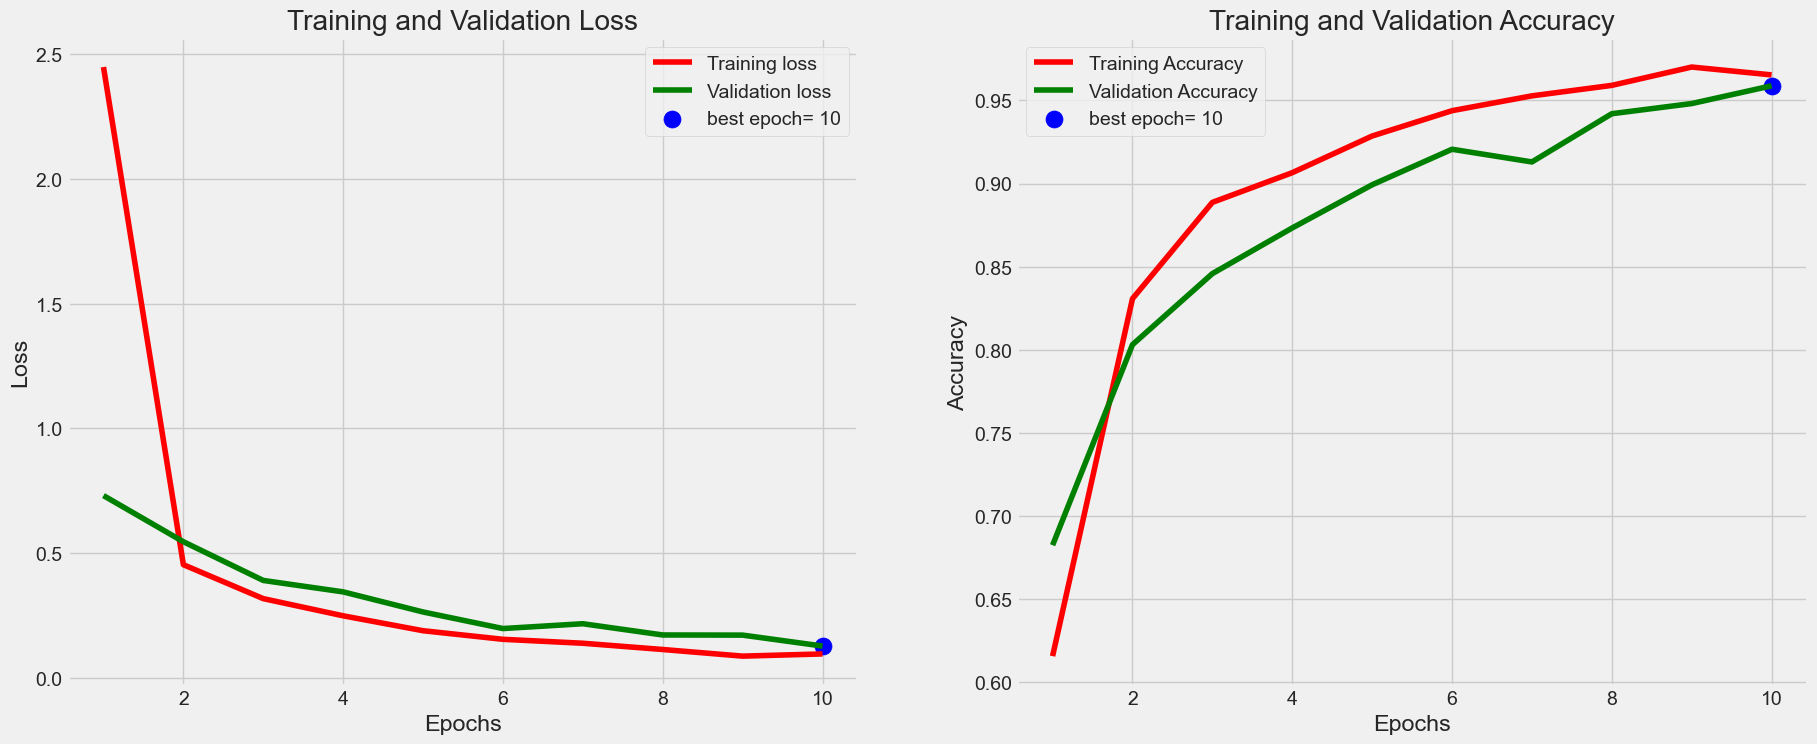

In [78]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [80]:
train_score = cnn_model.evaluate(train_gen, verbose= 1)
valid_score = cnn_model.evaluate(valid_gen, verbose= 1)
test_score = cnn_model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.9863 - loss: 0.0567
41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9551 - loss: 0.1451
41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9391 - loss: 0.1281
Train Loss:  0.056658096611499786
Train Accuracy:  0.986869752407074
--------------------
Validation Loss:  0.1272965371608734
Validation Accuracy:  0.9587786197662354
--------------------
Test Loss:  0.11775532364845276
Test Accuracy:  0.9512194991111755
